# Interactive clustering APP

In [56]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt

## Load data

In [60]:
VaVaI_DataFrame = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
VaVaI_columns = VaVaI_DataFrame.columns.to_list()

## Filter columns

In [61]:
multisel_columns = widgets.SelectMultiple(
    options=VaVaI_columns,
    disabled=False,
    rows=20,
)

select_button = widgets.Button(description='Select column(s)', icon='table')

widgets.VBox([multisel_columns, select_button])

In [62]:
selected_columns = list(multisel_columns.value)
selected_columns_df = VaVaI_DataFrame[selected_columns]
selected_columns_df.head()

,Název česky,Anotace česky,Hlavní CEP obor,Hlavní účastníci,Hlavní řešitelé,Klíčová slova,Poskytovatel
0,Účast neuroaktivních steroidů na mužské reprod...,Předmětem projektu je studium účasti neuroakti...,"FB - Endokrinologie, diabetologie, metabolismu...",NaN,NaN,allopregnanolone; pregnenolone; isomers of pre...,MZ - Ministerstvo zdravotnictví
1,Zkvalitnění péče o pacienty s cystickou fibróz...,Cílem je ověření efektivity (proveditelnosti a...,"FB - Endokrinologie, diabetologie, metabolismu...",NaN,NaN,cystic fibrosis; newborn screening; immunoreac...,MZ - Ministerstvo zdravotnictví
2,Molekulárně cytogenetická analýza buněk mozkov...,Molekulárně cytogenetická studie signifikantní...,EB - Genetika a molekulární biologie,NaN,NaN,brain tumours; chromosomal aberration; molecul...,MZ - Ministerstvo zdravotnictví
3,Modelování potenciálně antimykobakteriálně akt...,Syntéza nových potenciálně antimykobakteriálně...,FR - Farmakologie a lékárnická chemie,NaN,NaN,modeling; antitubercular; antifungal; cytotoxi...,MZ - Ministerstvo zdravotnictví
4,Rozvoj aplikací DNA čipů pro potřeby diagnosti...,Aplikace DNA čipů by měly významným způsobem p...,EB - Genetika a molekulární biologie,NaN,NaN,genetic diseases; metabolism; diagnostic; mole...,MZ - Ministerstvo zdravotnictví


## Clean the data

In [63]:
nan_rows = selected_columns_df.isna().any(axis=1)
cleaned_df = selected_columns_df[~nan_rows]

# Pair with the original df for future reference
VaVaI_DataFrame = VaVaI_DataFrame.iloc[cleaned_df.index]
cleaned_df.reset_index(inplace=True)
VaVaI_DataFrame.reset_index(inplace=True)
cleaned_df.drop(columns='index', inplace=True)
display(cleaned_df.head())

del selected_columns_df

,Název česky,Anotace česky,Hlavní CEP obor,Hlavní účastníci,Hlavní řešitelé,Klíčová slova,Poskytovatel
0,"Frekvence a distribuce inzulinorezistence, jak...",Stanovení jednoduchých kvantitativních indexů ...,"FB - Endokrinologie, diabetologie, metabolismu...",Univerzita Palackého v Olomouci / Lékařská fak...,prof. MUDr. Vladimír Janout CSc. (vedidk=25123...,insulin resistance; quantitative indexes; HOMA...,MZ - Ministerstvo zdravotnictví
1,13 let jako významný milník v životě dětí - ep...,Budou šetřeny výzkumné děti ve 13 letech jejic...,FM - Hygiena,Masarykova univerzita / Lékařská fakulta (pare...,MUDr. Lubomír Kukla CSc. (vedidk=5814871),injury rate; morbidity; environment; lifestyle...,MZ - Ministerstvo zdravotnictví
2,Modely financování opatření k ochraně životníh...,Navrhnout model financování aspektů životního ...,AH - Ekonomie,Allowance s.r.o. (IČO: 26140136),Mgr. Drahomír Mezr (vedidk=6748791),financial models; system of financing of envir...,MŽP - Ministerstvo životního prostředí
3,Ověření účinnosti dobrovolných nástrojů ochran...,Dosažení cílů udržitelného rozvoje a kvality ž...,"DM - Tuhý odpad a jeho kontrola, recyklace",ČESKÉ EKOLOGICKÉ MANAŽERSKÉ CENTRUM (IČO: 4524...,PhDr. Věra Havránková (vedidk=3579417),Sustainable development; models of production;...,MŽP - Ministerstvo životního prostředí
4,Aplikace environmentálního účetnictví na mikro...,Projekt řeší problematiku udržitelného rozvoje...,EH - Ekologie – společenstva,ČESKÉ EKOLOGICKÉ MANAŽERSKÉ CENTRUM (IČO: 4524...,Ing. Jiří Študent (vedidk=5621542),macro-economical account; SEEA 2003; EMS; envi...,MŽP - Ministerstvo životního prostředí


## Preprocess data
- concat
- convert to lowercase
- remove punctuation
- tokenize
- remove stop-words

In [64]:
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords

def display_head(df):
    print('=========================================')
    for i in range(5):
        print(df[i][:100])
        print()
    
def remove_stopwords(x):
    sw = stopwords.words('english')
    sw.extend(['aim', 'goal', 'attempt', 'project', 'evaluate', 'research', 'improve', 'improvement', 'development'])
    new_sentence = []
    for word in x:
        if word not in sw:
            new_sentence.append(word)
    return new_sentence

def lemmatize_text(text):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

processed_data = cleaned_df.apply(' '.join, axis=1).astype(str)
display_head(processed_data)

processed_data = processed_data.apply(str.lower)
display_head(processed_data)

processed_data = processed_data.apply(lambda x: re.sub(r"[{}]".format(punctuation), ' ', x))
display_head(processed_data)

processed_data = processed_data.apply(lemmatize_text)
display_head(processed_data)

processed_data = processed_data.apply(remove_stopwords)
display_head(processed_data)

Frekvence a distribuce inzulinorezistence, jako rizikového faktoru kardiovaskulárních a metabolickýc

13 let jako významný milník v životě dětí - epidemiologická studie Budou šetřeny výzkumné děti ve 13

Modely financování opatření k ochraně životního prostředí Navrhnout model financování aspektů životn

Ověření účinnosti dobrovolných nástrojů ochrany životního prostředí pro politiku prevence a správnéh

Aplikace environmentálního účetnictví na mikroekonomické a makroekonomické úrovni v podmínkách ČR Pr

frekvence a distribuce inzulinorezistence, jako rizikového faktoru kardiovaskulárních a metabolickýc

13 let jako významný milník v životě dětí - epidemiologická studie budou šetřeny výzkumné děti ve 13

modely financování opatření k ochraně životního prostředí navrhnout model financování aspektů životn

ověření účinnosti dobrovolných nástrojů ochrany životního prostředí pro politiku prevence a správnéh

aplikace environmentálního účetnictví na mikroekonomické a makroekonomické úrovni 

## Vectorize
- TF-IDF
- Word2Vec
- Doc2Vec

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_using_tf_idf(data, min_n=1, max_n=5):
    result = {}
    for i in range(min_n, max_n + 1):
        for j in range(min_n, max_n + 1):
            if i > j: continue
            print(f'Fitting TF-IDF for ngram range: ({i},{j})')
            transformer = TfidfVectorizer(ngram_range=(min_n, max_n))
            vectorized = transformer.fit_transform(data.apply(' '.join))
            result[f'tf-idf_({i},{j})'] = vectorized
    return result

In [66]:
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

model_names = ['fasttext-wiki-news-subwords-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50',
               'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 
               'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']

def word2vec(data, model_name):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = [word for word in sentence if word in model]
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(model[doc], axis=0)
    
    print(f'Loading model: {model_name}')
    model = api.load(model_name)
    vectorized = data.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_pretrained_word2vec(data):
    results = {}
    for model_name in model_names:
        vectorized = word2vec(data, model_name)
        results[f'word2vec_({model_name})'] = vectorized
    return results

In [74]:
def word2vec_train(df, vector_size, epochs):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = np.array([model.wv[word] for word in sentence])
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(doc, axis=0)
    
    print(f'Training Word2Vec model with vector size {vector_size} for {epochs}')
    data = df.to_list()
    model = Word2Vec(sentences=data, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs)
    model.save(f'word2vec_{vector_size}_{epochs}')
    
    vectorized = df.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_word2vec(data):
    results = {}
    for vs in [25, 50, 100, 200]:
        for ep in [10, 25, 50, 100]:
            vectorized = word2vec_train(data, vs, ep)
            results[f'word2vec_{vs}_{ep}'] = vectorized
    return results

In [75]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def doc2vec_train(data, vector_size, epochs):
    print(f'Training Doc2Vec model with vector size {vector_size} for {epochs} epochs')
    model = Doc2Vec(documents=data, 
                    vector_size=vector_size, 
                    window=5, 
                    min_count=1, 
                    workers=8,
                    hs=1,
                    epochs=epochs)
    model.save(f'doc2vec_{vector_size}_{epochs}')
    return np.array([model.dv[i] for i in range(len(data))])

def vectorize_using_doc2vec(data):
    results = {}
    tagged_data = [TaggedDocument(words=sentence, tags=[index]) for sentence, index in zip(data, list(data.index))]
    for vs in [25, 50, 100, 200, 300]:
        for ep in [10, 50, 100, 200, 500]:
            vectorized = doc2vec_train(tagged_data, vs, ep)
            results[f'doc2vec_{vs}_{ep}'] = vectorized
    return results

In [76]:
models = {
    'TF-IDF': vectorize_using_tf_idf,
    'Word2Vec-Pretrained': vectorize_using_pretrained_word2vec,
    'Word2Vec': vectorize_using_word2vec,
    'Doc2Vec': vectorize_using_doc2vec
}

multisel_models = widgets.SelectMultiple(
    options=list(models.keys()),
    disabled=False,
    rows=10,
)

select_button = widgets.Button(description='Select Models', icon='table')

widgets.VBox([multisel_models, select_button])

In [77]:
import pickle

selected_models = list(multisel_models.value)
print(selected_models)
sampled_data = processed_data.sample(n=1000, random_state=42)

results = {}
for model in selected_models:
    results = {**results, **models[model](processed_data)}
    
with open('vectors.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

['Word2Vec']
Training Word2Vec model with vector size 25 for 10
Training Word2Vec model with vector size 25 for 25
Training Word2Vec model with vector size 25 for 50
Training Word2Vec model with vector size 25 for 100
Training Word2Vec model with vector size 50 for 10
Training Word2Vec model with vector size 50 for 25
Training Word2Vec model with vector size 50 for 50
Training Word2Vec model with vector size 50 for 100
Training Word2Vec model with vector size 100 for 10
Training Word2Vec model with vector size 100 for 25
Training Word2Vec model with vector size 100 for 50
Training Word2Vec model with vector size 100 for 100
Training Word2Vec model with vector size 200 for 10
Training Word2Vec model with vector size 200 for 25
Training Word2Vec model with vector size 200 for 50
Training Word2Vec model with vector size 200 for 100


In [35]:
#TODO: remove this cell after testing
model = Doc2Vec.load('word2vec_200')

print(processed_data[0])
vec = model.infer_vector(processed_data[0])

similar = model.docvecs.most_similar([vec])

display(similar)

['frekvence', 'distribuce', 'inzulinorezistence', 'jako', 'rizikového', 'faktoru', 'kardiovaskulárních', 'metabolických', 'onemocněni', 'stanovení', 'jednoduchých', 'kvantitativních', 'indexů', 'homa', 'ir', 'quicki', 'u', 'skupin', 'osob', 'intolerancí', 'glukózy', 'diabetem', 'typu', '2', 'hyperlipidémií', 'obezitou', 'hypertenzí', 'kombinací', 'faktorů', 'srovnání', 'se', 'zdravými', 'jedinci', 'pro', 'posouzení', 'časného', 'stádia', 'inzulínové', 'rezistencepokus', 'stanovení', 'hraniční', 'hodnoty', 'která', 'odlišovala', 'osoby', 'rizikem', 'inzulínové', 'rezistence', 'osoby', 'bez', 'rizika', 'fb', 'endokrinologie', 'diabetologie', 'metabolismus', 'výživa', 'univerzita', 'palackého', 'v', 'olomouci', 'lékařská', 'fakulta', 'parent', 'ičo', '61989592', 'prof', 'mudr', 'vladimír', 'janout', 'csc', 'vedidk', '2512343', 'orcid', '0000', '0002', '1163', '0361', 'mz', 'ministerstvo', 'zdravotnictví']


AttributeError: 'Word2Vec' object has no attribute 'infer_vector'

## Cluster
- KMeans
- Hiearchical

In [79]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def cluster_using_kmeans(data, ax):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 40), ax=ax)
    visualizer.fit(data)

In [78]:
from pyclustertend import hopkins

def calc_hopkins_score(vector):
    if hasattr(vector, 'toarray'):
        vector = vector.toarray()
    df = pd.DataFrame(vector)
    hs = hopkins(df, vector.shape[0])
    print(f'Hopkins score for {name}: {hs:5f}')
    
for name, vector in results.items():
    calc_hopkins_score(vector)

Hopkins score for word2vec_25_10: 0.177169
Hopkins score for word2vec_25_25: 0.188311
Hopkins score for word2vec_25_50: 0.184769
Hopkins score for word2vec_25_100: 0.182836
Hopkins score for word2vec_50_10: 0.181696
Hopkins score for word2vec_50_25: 0.190929
Hopkins score for word2vec_50_50: 0.190229
Hopkins score for word2vec_50_100: 0.189133
Hopkins score for word2vec_100_10: 0.180715
Hopkins score for word2vec_100_25: 0.194050
Hopkins score for word2vec_100_50: 0.193722
Hopkins score for word2vec_100_100: 0.192426
Hopkins score for word2vec_200_10: 0.176429
Hopkins score for word2vec_200_25: 0.194508
Hopkins score for word2vec_200_50: 0.200362
Hopkins score for word2vec_200_100: 0.198815


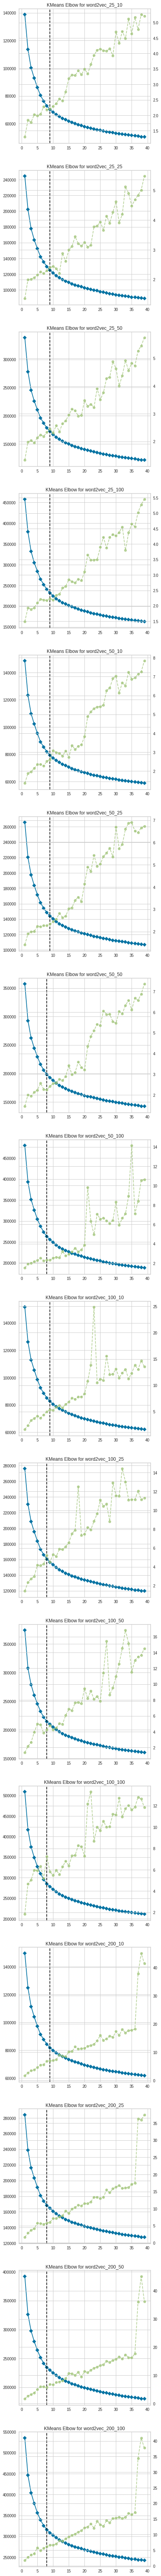

In [82]:
fig, axes = plt.subplots(len(results), figsize=(6,120))

for idx, (name, vector) in enumerate(results.items()):
    print(f'Fitting elbow for {name}')
    cluster_using_kmeans(vector, axes[idx])
    axes[idx].set_title(f'KMeans Elbow for {name}')
    
plt.savefig('kmeans_elbow_all_word2vec_czech.png')
plt.show()

## Evaluate & Visualize clustering

In [84]:
multisel_models = widgets.Select(
    options=list(res.keys()),
    disabled=False,
    rows=10,
)

select_button = widgets.Button(description='Select Model', icon='table')

widgets.VBox([multisel_models, select_button])

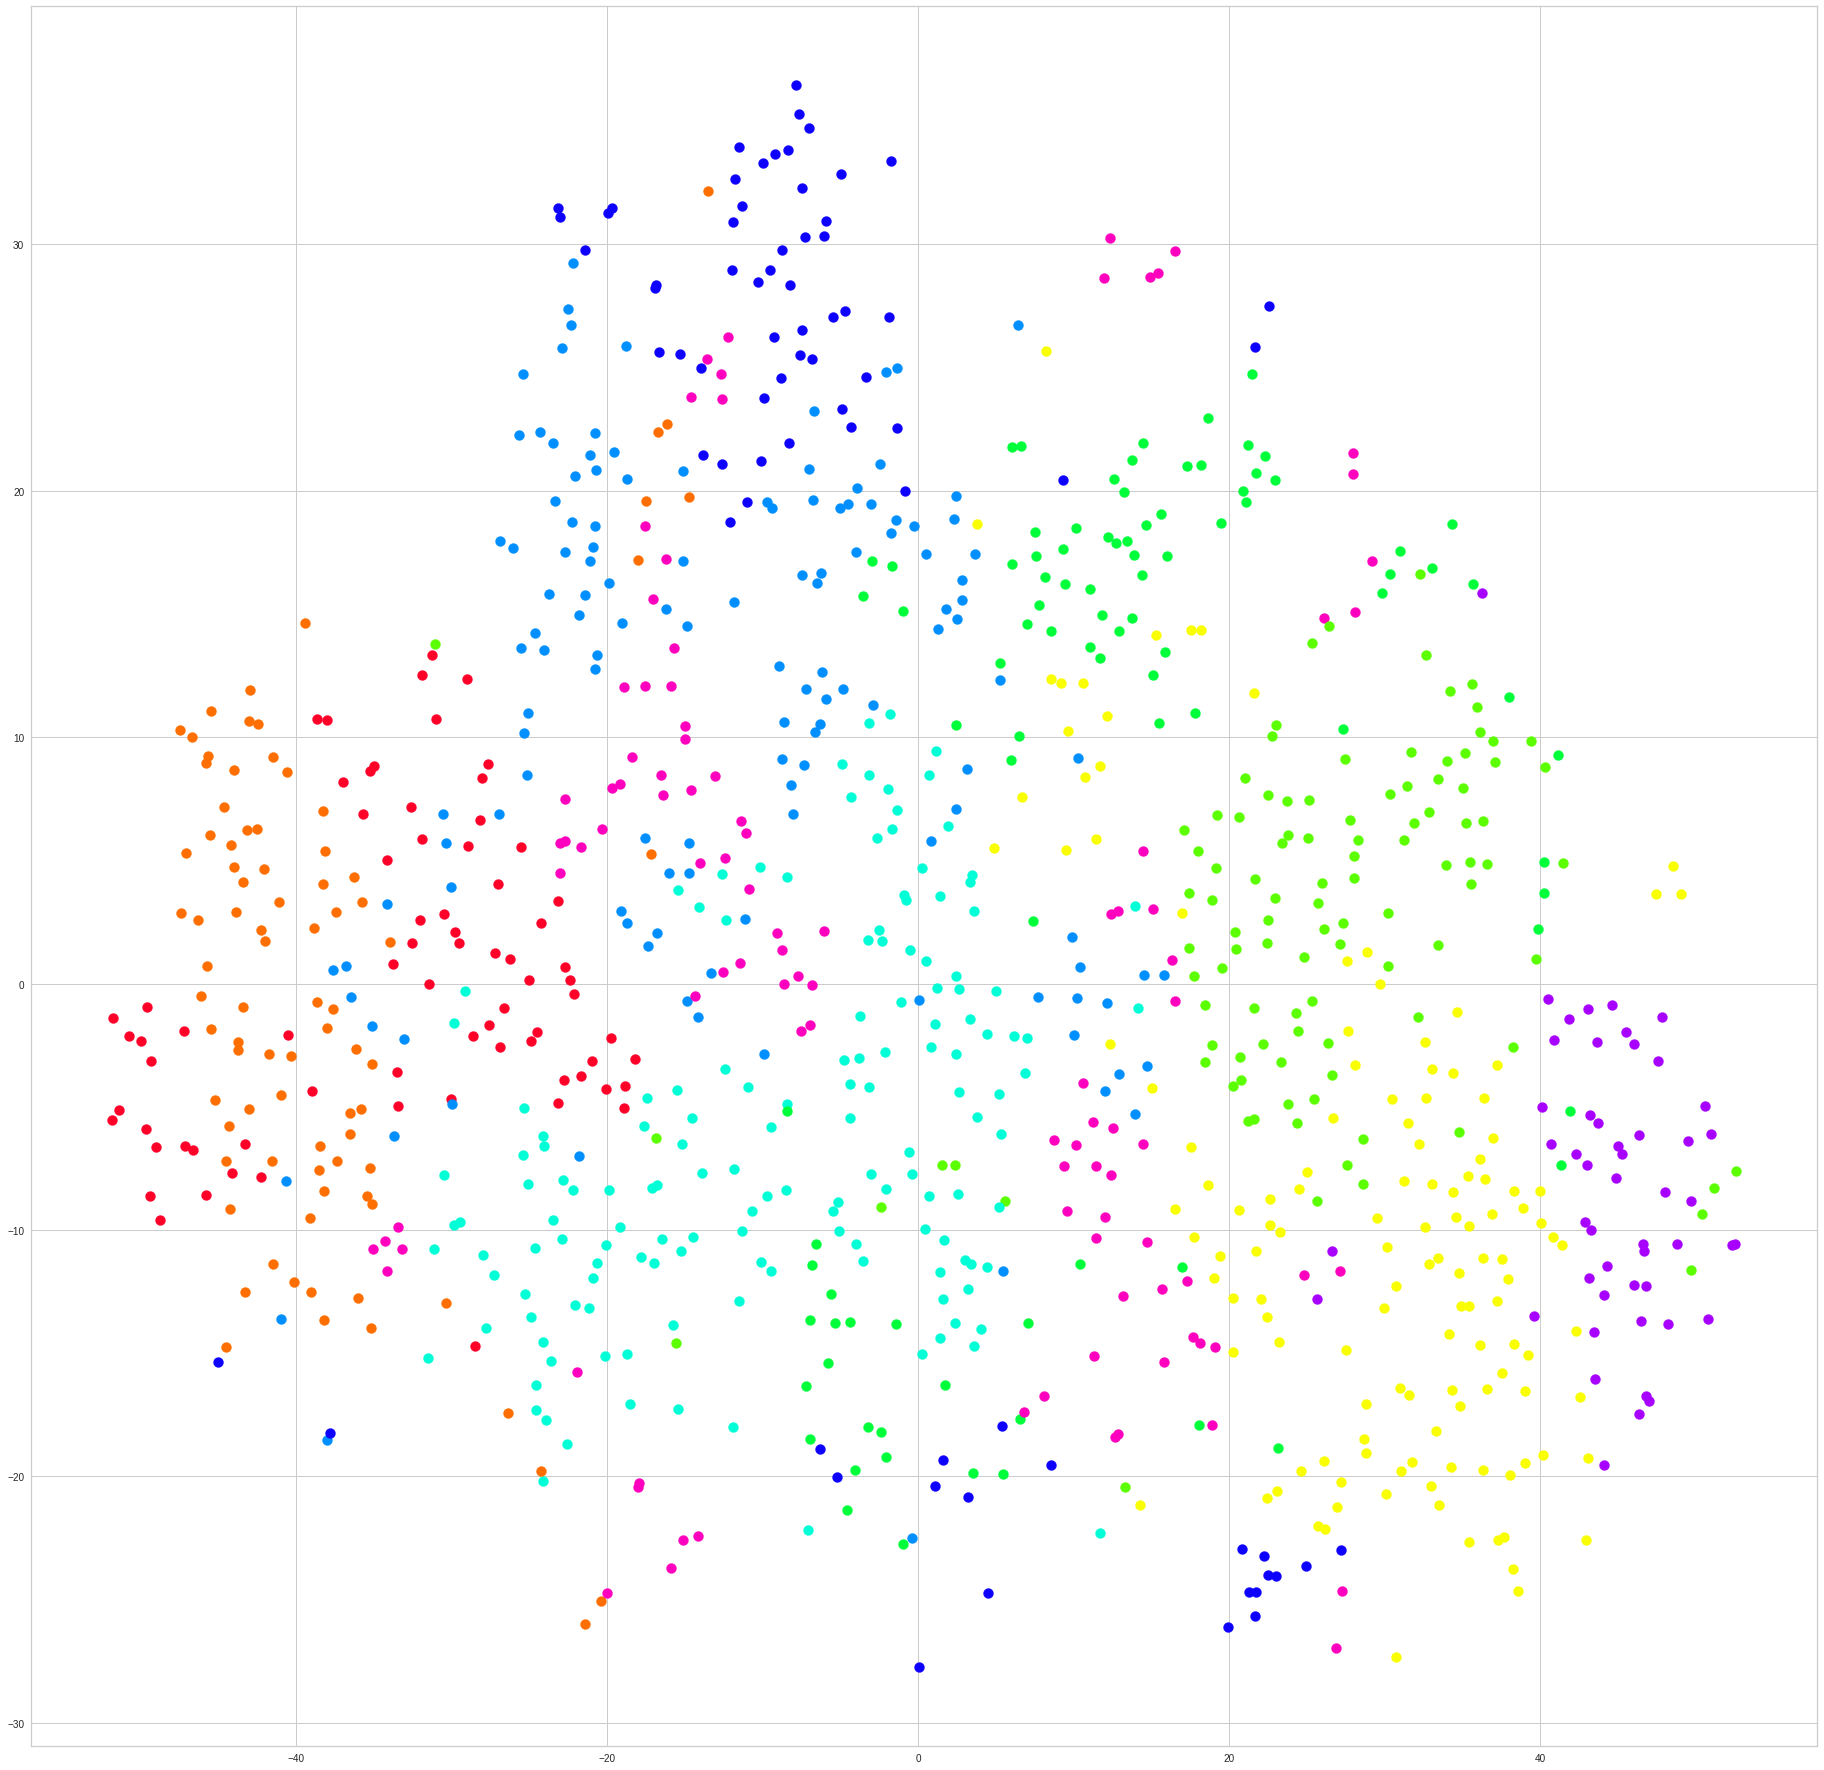

In [117]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm


def visualize_clusters(vector):
    x = np.arange(10)
    ys = [i+x+(i*x)**2 for i in range(10)]
    colors = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
    
    clusterer = KMeansClusterer(10, euclidean_distance)
    clustered = clusterer.cluster(vector, assign_clusters=True)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=25000, random_state=23, n_jobs=-1)
    tsne_clusters = tsne_model.fit_transform(vector)
    
    x = []
    y = []
    for value in tsne_clusters:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=colors[clustered[i]], s=100)
    
visualize_clusters(res[multisel_models.value])

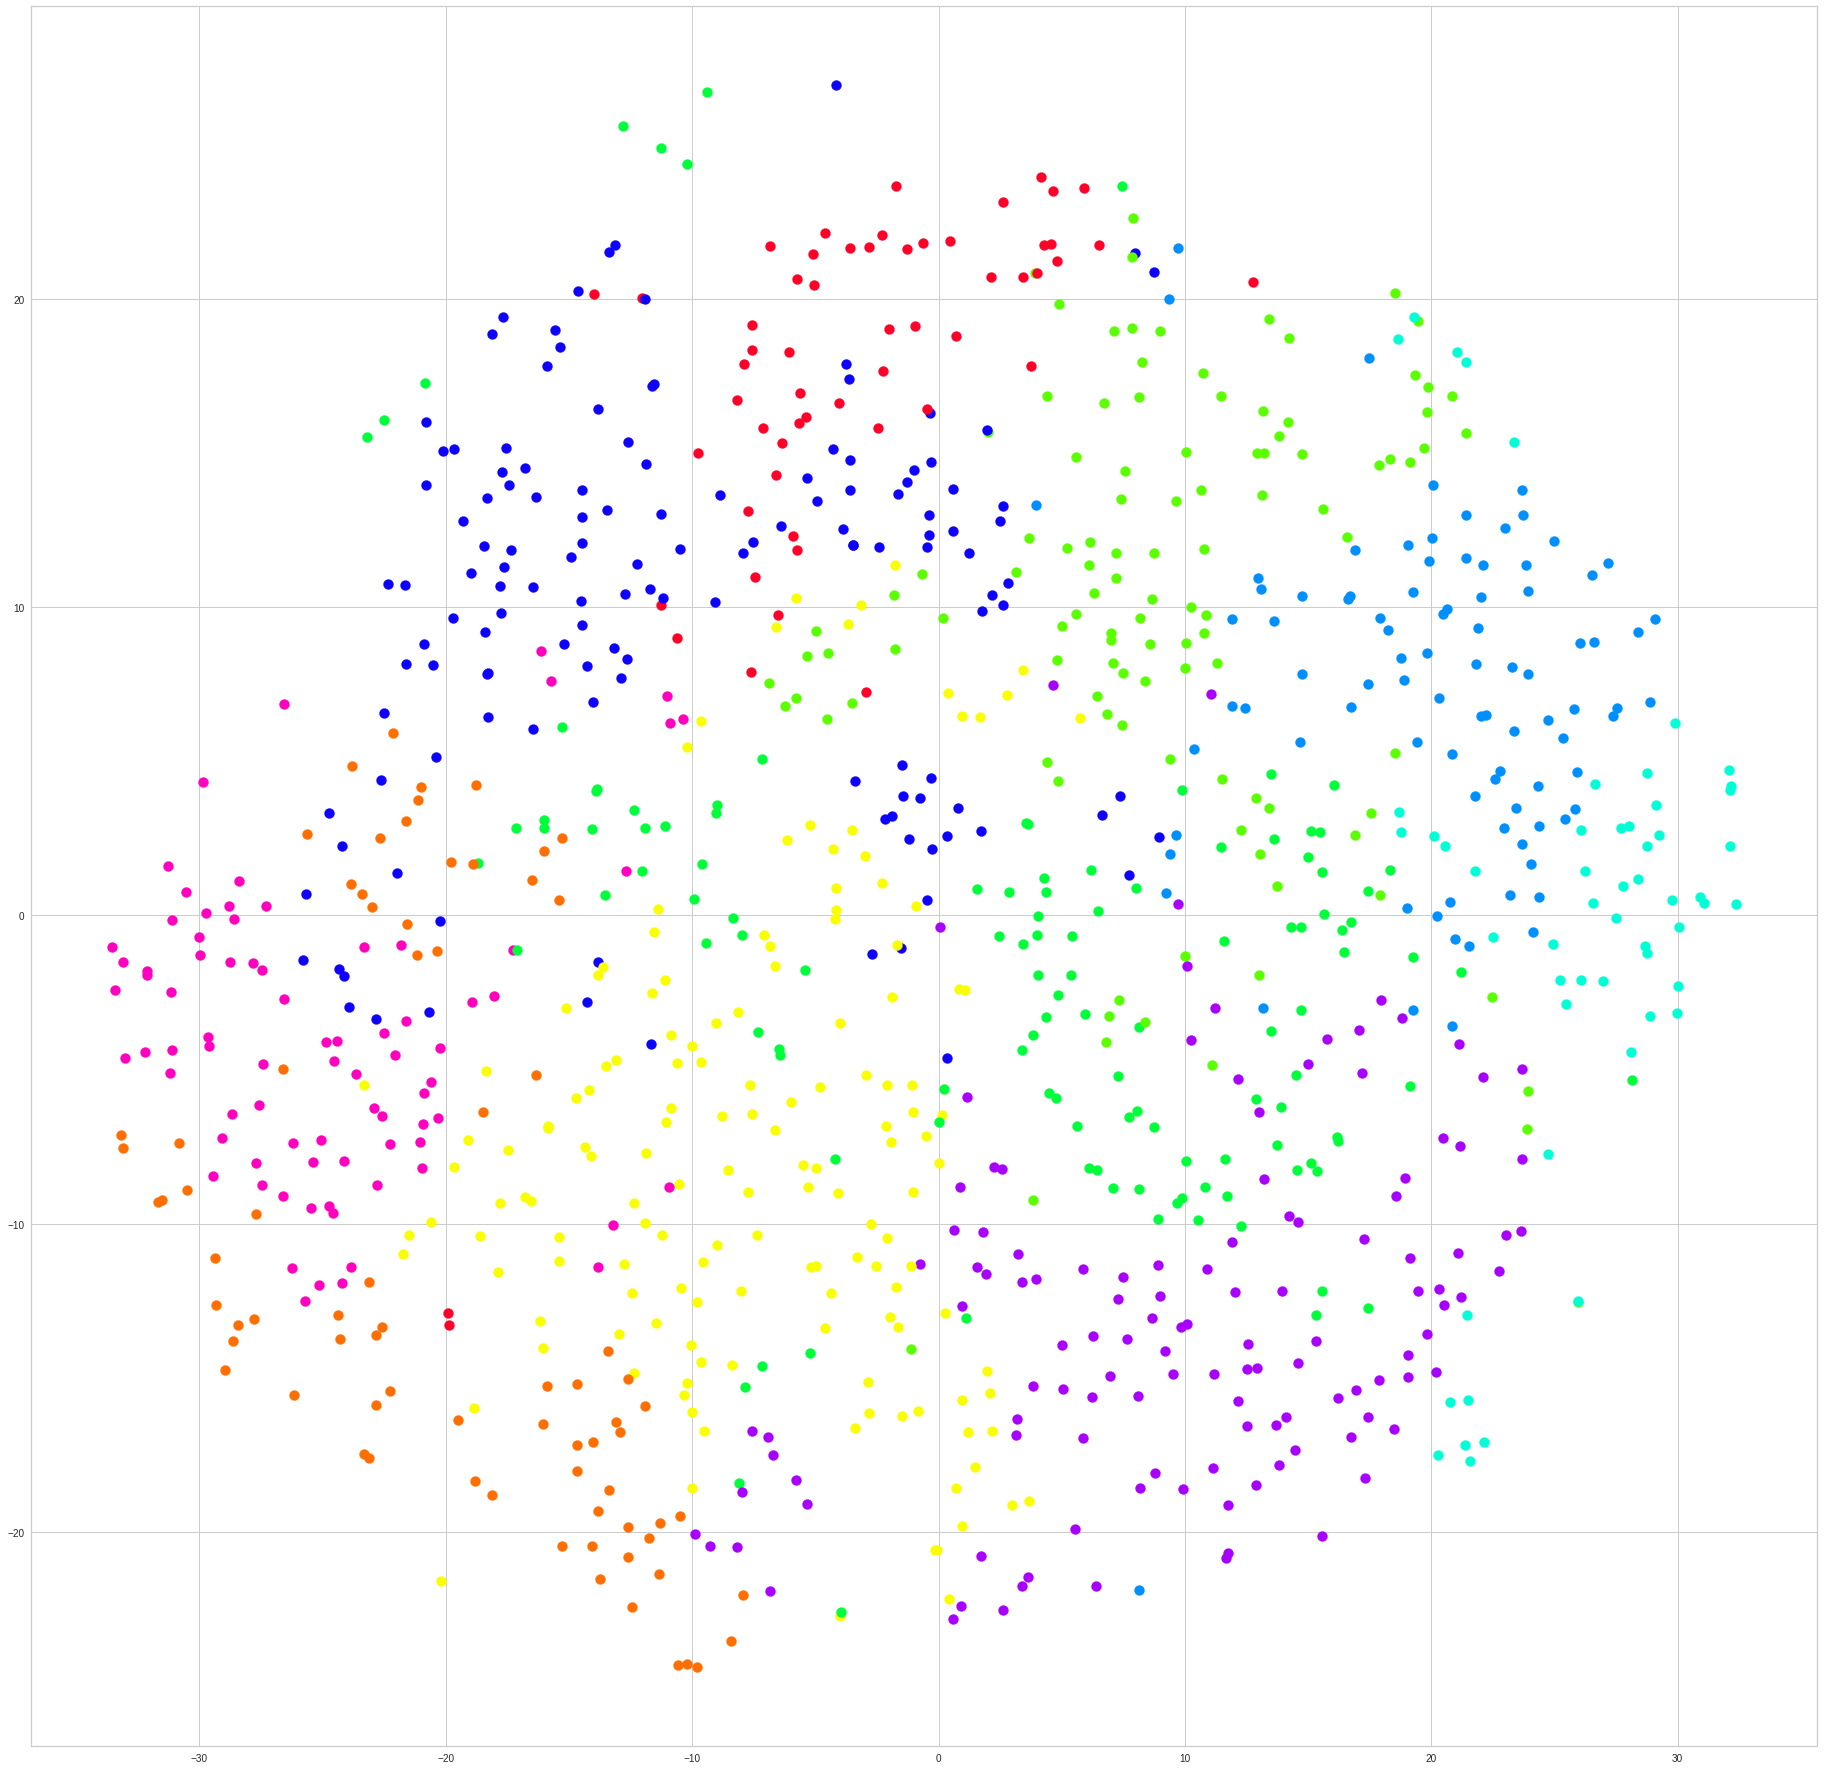

In [115]:
visualize_clusters(res[multisel_models.value])

In [125]:
hopkins(pd.DataFrame(res[multisel_models.value]), res[multisel_models.value].shape[0])

0.1807210840577872

In [123]:
multisel_models.value

'word2vec_(fasttext-wiki-news-subwords-300)'

['u',
 's',
 'i',
 'n',
 'g',
 ' ',
 'd',
 'n',
 'a',
 ' ',
 'g',
 'e',
 'n',
 'e',
 'r',
 'a',
 't',
 'e',
 ' ',
 'l',
 'i',
 'g',
 'h',
 't',
 ' ',
 'v',
 'i',
 't',
 'r',
 'o',
 ' ',
 's',
 'e',
 'l',
 'e',
 'c',
 't',
 'i',
 'o',
 'n',
 ' ',
 'h',
 'a',
 ' ',
 'u',
 's',
 'e',
 'd',
 ' ',
 'g',
 'e',
 'n',
 'e',
 'r',
 'a',
 't',
 'e',
 ' ',
 'w',
 'i',
 'd',
 'e',
 ' ',
 'v',
 'a',
 'r',
 'i',
 'e',
 't',
 'y',
 ' ',
 'n',
 'u',
 'c',
 'l',
 'e',
 'i',
 'c',
 ' ',
 'a',
 'c',
 'i',
 'd',
 ' ',
 'm',
 'o',
 't',
 'i',
 'f',
 ' ',
 'p',
 'o',
 't',
 'e',
 'n',
 't',
 'i',
 'a',
 'l',
 ' ',
 'f',
 'a',
 'c',
 'i',
 'l',
 'i',
 't',
 'a',
 't',
 'e',
 ' ',
 'b',
 'a',
 's',
 'i',
 'c',
 ' ',
 'c',
 'o',
 'm',
 'p',
 'l',
 'e',
 'm',
 'e',
 'n',
 't',
 ' ',
 'g',
 'r',
 'o',
 'w',
 'i',
 'n',
 'g',
 ' ',
 't',
 'o',
 'o',
 'l',
 'k',
 'i',
 't',
 ' ',
 'f',
 'u',
 'n',
 'c',
 't',
 'i',
 'o',
 'n',
 'a',
 'l',
 ' ',
 'e',
 'l',
 'e',
 'm',
 'e',
 'n',
 't',
 ' ',
 'd',
 'e',
 's',
 'c'